<a href="https://colab.research.google.com/github/lkarjun/reverse-image-search/blob/main/rimg_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Packages

In [1]:
!pip install fastai -Uqq

In [115]:
from fastai.vision.all import *
from torch.optim import AdamW
from tqdm import tqdm

## Download dataset

In [3]:
import os
os.environ['KAGGLE_USERNAME'] = "lkarjun"
os.environ['KAGGLE_KEY'] = "96d0e367426087ce8a91876ea3de5244"

In [ ]:
!kaggle datasets download -d duttadebadri/image-classification
!unzip image-classification.zip

In [8]:
dataset_path = Path("/content/images/images")

## Here we go

### Dataloader

In [54]:
def get_fnames(dataset_path, folders: list, n_files = 300):
  fnames = []
  for folder in folders:
    fnames += get_image_files(dataset_path/folder)[:n_files]
  return fnames

In [55]:
fnames = get_fnames(dataset_path, ['architecure', 'art and culture'])

In [56]:
ITEM_TFMS = Resize(224)

BATCH_TFMS = Normalize.from_stats(*imagenet_stats)

BATCH_SIZE = 64

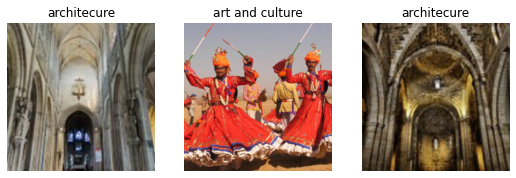

In [57]:
dls = ImageDataLoaders.from_path_func(dataset_path, fnames, 
                                      parent_label,
                                      batch_tfms = BATCH_TFMS, 
                                      item_tfms = ITEM_TFMS, 
                                      bs=BATCH_SIZE)

dls.show_batch(max_n = 3)

In [59]:
x, y = dls.one_batch()
x.shape, y.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

### Model

In [60]:
body = create_body(resnet34, cut=-2)

In [61]:
head = create_head(nf = num_features_model(body), 
                   lin_ftrs=[512, 128],
                   n_out = 2, 
                   concat_pool=False, 
                   pool=True)
head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [78]:
class RImgModel(Module):
    def __init__(self, body,head):
        self.body = body
        self.head = head
    
    def forward(self, x):
        x = self.body(x)
        return self.head(x)

In [79]:
model = RImgModel(body, head).cuda()

In [80]:
def model_splitter(model):
    return L(model.body, model.head).map(params)

In [81]:
learn = Learner(dls, model,
                splitter = model_splitter, 
                metrics=accuracy)

In [82]:
learn.summary()

RImgModel (Input shape: 64 x 3 x 224 x 224)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 64 x 112 x 112 
Conv2d                                    9408       False     
BatchNorm2d                               128        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 56 x 56   
MaxPool2d                                                      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
Conv2d                                    36864      False     
BatchNorm2d                               128        True      
ReLU                       

In [83]:
learn.freeze()

In [84]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.023613,0.017898,0.991667,00:07
1,0.015416,0.074443,0.991667,00:06
2,0.011356,0.089397,0.991667,00:06
3,0.009718,0.074003,0.991667,00:06


In [85]:
# lower lr for body and high for head
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.006034,0.069680,0.991667,00:07
1,0.005776,0.063313,0.991667,00:06
2,0.025377,0.053746,0.991667,00:07
3,0.018968,0.055491,0.991667,00:07


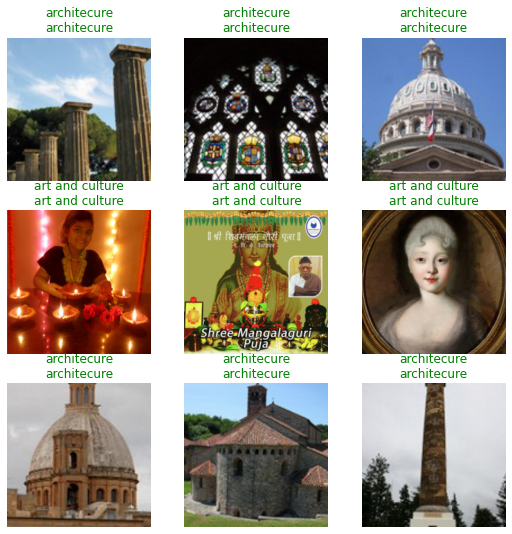

In [86]:
learn.show_results()

### Geting feature vector

In [87]:
model.head

Sequential(
  (0): AdaptiveAvgPool2d(output_size=1)
  (1): Flatten(full=False)
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25, inplace=False)
  (4): Linear(in_features=512, out_features=512, bias=False)
  (5): ReLU(inplace=True)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.25, inplace=False)
  (8): Linear(in_features=512, out_features=128, bias=False)
  (9): ReLU(inplace=True)
  (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=False)
)

In [116]:
def get_feature_vector(dl):
  with hook_output(learn.model.head[8]) as h:
    y = learn.get_preds(dl=dl)
  return h.stored

In [99]:
dl = learn.dls.test_dl(fnames)

In [123]:
features = []

for i in tqdm(range(0, len(fnames), BATCH_SIZE)):
    names = fnames[i:i + BATCH_SIZE]
    dl = learn.dls.test_dl(names)
    features += get_feature_vector(dl)

features = torch.stack(features, dim = 0).cpu().numpy()

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:04,  2.19it/s]

 20%|██        | 2/10 [00:00<00:03,  2.24it/s]

 30%|███       | 3/10 [00:01<00:03,  2.28it/s]

 40%|████      | 4/10 [00:01<00:02,  2.28it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.77it/s]

 60%|██████    | 6/10 [00:04<00:03,  1.09it/s]

 70%|███████   | 7/10 [00:05<00:03,  1.21s/it]

 80%|████████  | 8/10 [00:07<00:02,  1.23s/it]

 90%|█████████ | 9/10 [00:08<00:01,  1.32s/it]

100%|██████████| 10/10 [00:09<00:00,  1.00it/s]


### Similar Images

In [161]:
from sklearn.neighbors import NearestNeighbors


neighbors = NearestNeighbors(n_neighbors=10, algorithm='brute',metric='euclidean')

In [162]:
neighbors.fit(features)

NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=10)

In [172]:
test_idx = 100

In [173]:
distances, indices = neighbors.kneighbors([features[test_idx]], 6)

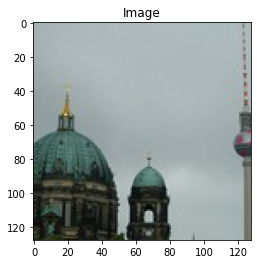

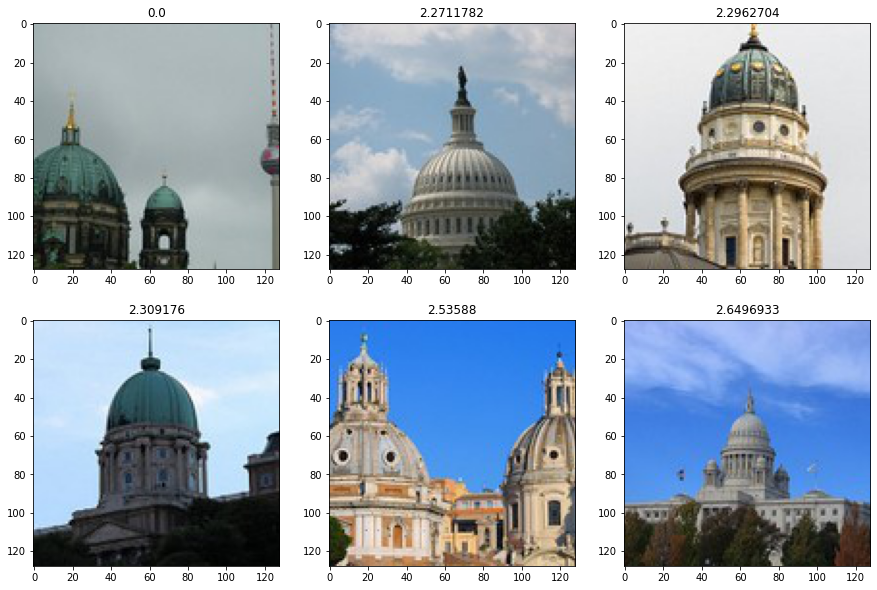

In [174]:
plt.imshow(Image.open(fnames[test_idx]))
plt.title("Image")

fig, axs = plt.subplots(2,3, figsize=(15, 10))

for ax, idx, dis in zip(axs.flatten(), indices.flatten(), distances.flatten()):
  img = Image.open(fnames[idx])
  ax.imshow(img)
  ax.set_title(dis)